# Speed comparison of Japanese tokenizers

I referred to below page.

[Python で分かち書き の速度比較 / janome, sudachi, ginza, mecab, fugashi, tinysegmenter - Qiita](https://qiita.com/kfjt/items/8b2f4a04e4befff18e19)

In [37]:
import time
from typing import List, Callable

from janome.tokenizer import Tokenizer as JanomeTokenizer
from MeCab import Tagger as MeCabTagger
from sudachipy import dictionary as sudachi_dic

import requests

import pandas as pd
import seaborn as sns

In [2]:
NEKO_TEXT = (
    requests
    .get(
        "http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt"
    )
    .content
    .decode()
)

In [13]:
mecab_tokenizer = MeCabTagger("-Owakati")
janome_tokenizer = JanomeTokenizer()
sudachi_tokenizer = sudachi_dic.Dictionary().create()

In [17]:
def mecab(text: str) -> List[str]:
    ret: List[str] = mecab_tokenizer.parse(text).split()
    return ret


def janome(text: str) -> List[str]:
    return [
        token for token in janome_tokenizer.tokenize(text, wakati=True)
    ]


def sudachi(text: str) -> List[str]:
    return [
        token.surface() for token in sudachi_tokenizer.tokenize(text)
    ]

In [19]:
def elapsed_times(func: Callable, trial_times: int = 100) -> List[int]:
    print(f"start: {func}")
    ret: List[int] = []
    ret_append = ret.append
    for _ in range(trial_times):
        start = time.perf_counter_ns()
        func(NEKO_TEXT)
        end = time.perf_counter_ns()
        ret_append(end - start)
    print(f"end: {func}")
    return ret

In [21]:
results = {
    tokenizer_name: elapsed_times(globals()[tokenizer_name], trial_times=10)
    for tokenizer_name in ("mecab", "janome", "sudachi")
}

start: <function mecab at 0x7fed1efed4c0>
end: <function mecab at 0x7fed1efed4c0>
start: <function janome at 0x7fed09fa91f0>
end: <function janome at 0x7fed09fa91f0>
start: <function sudachi at 0x7fed09fa9040>
end: <function sudachi at 0x7fed09fa9040>


In [35]:
df = pd.DataFrame.from_dict(results)
data = df.melt(
    value_name="elapsed time",
    var_name="tokenizer name",
)
data["elapsed time [ms]"] = data["elapsed time"] / 1000 / 1000

<AxesSubplot:xlabel='tokenizer name', ylabel='elapsed time [ms]'>

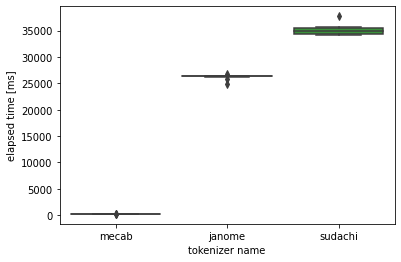

In [36]:
sns.boxplot(
    data=data,
    y="elapsed time [ms]",
    x="tokenizer name",
)